# **An Analysis of Previous Elections to Forecast Outcomes**
Summer 2024 Data Science Project by Kayla Marie Valdez

<br>

<hr>

### **Introduction**

With the 2024 Presidential Election approaching, I was curious to see how my newfound data science skills could be used, and I realized there would be an abundance of data on past elections. After learning how to take data and predict outcomes, I understood I could use these skills to answer the question: "How well can previous elections predict future ones?"

For US voters, answering this question increases our awareness on how political landscapes shift over time. This analysis alone will boost our engagement in the political process, possibly motivating more US citizens to participate in elections and civic activities. Ultimately, elections directly impact various aspects of our lives, from healthcare to education. Understanding how past elections have shaped current policies can help us make decisions that align with our personal interests and values.

### **Data Curation**

The US election results data used in this tutorial was downloaded from [Kaggle](https://www.kaggle.com/datasets) and GitHub:
*   [1976-2020-president.csv](https://www.kaggle.com/datasets/tunguz/us-elections-dataset/data) : This data holds all US Presidential Election results by state, starting from 1976 to 2020. For this analysis, we only need the *year*, *state_po*, *candidate*, *candidate_votes*, and *party_simplified* columns.
*   [1976-2022-house-two-party-vote-by-state.csv](https://github.com/Eurcrue/elections-playground/blob/main/processed_data/1976-2022-house-two-party-vote-by-state.csv) : This data consists of House of Representatives Election results by state, starting from 1976 to 2022. It specifically focuses on the percentage of votes received by Democrats and Republicans in each election year and state.



Below are the libraries necessary for this tutorial:

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

from scipy.stats import linregress
from scipy.stats import zscore
from sklearn.linear_model import ElasticNetCV

Before analyzing the data, we need to preprocess it to create a clean dataframe that contains the relevant information. Keep in mind that for exploration purposes, we are only counting votes for Democrats and Republicans.

In [78]:
pres_df = pd.read_csv('1976-2020-president.csv')
house_df = pd.read_csv('1976-2022-house-two-party-vote-by-state.csv')

# Cleaning up pres_df to show the percentage of Democratic and Republican votes for each state and Presidential Election year
data = pres_df[['year', 'state_po', 'candidate', 'candidatevotes', 'party_simplified']]
data = data.rename(columns = {'state_po': 'state', 'candidatevotes': 'votes', 'party_simplified': 'party'})
data = data.dropna()

data = data.groupby(['year', 'state', 'candidate'])[['votes', 'party']]\
        .apply(lambda table: pd.Series({'votes' : table['votes'].sum(),
                              'party': table.sort_values(by='votes', ascending = False)['party'].iloc[0]}))\
        .reset_index()

data = data[data['candidate'] != 'PEROT, ROSS']
data = data.groupby(['year', 'state'])[['candidate', 'party', 'votes']]\
                .apply(lambda table : table.sort_values(by = 'votes', ascending = False)[:2])\
                .reset_index()\
                .drop(columns = 'level_2')

data = data.drop(columns = 'candidate')
pres_data = data.pivot(index = ['year', 'state'], columns = 'party', values = 'votes').reset_index()

pres_data['total'] = pres_data['DEMOCRAT'] + pres_data['REPUBLICAN']
pres_data['dem_pct'] = pres_data['DEMOCRAT']/pres_data['total']
pres_data['rep_pct'] = pres_data['REPUBLICAN']/pres_data['total']
pres_data = pres_data[['year', 'state', 'dem_pct', 'rep_pct']]

# Formatting house_df the same way we formatted pres_df
house_data = house_df.pivot(index = ['year', 'state'], columns = 'party', values = 'two_party_pct').reset_index()

We want to combine **pres_data** and **house_data** to show both Presidential Election and House of Representative Election results from previous years with respect to presidential results of the current year.

In [79]:
# Creating columns for a combined dataframe
dfs = []
for i in range(2,13,2):
  temp_pres = pres_data[['year', 'state', 'rep_pct']]
  temp_pres.loc[:,'year'] = temp_pres['year'] + i
  temp_pres = temp_pres.rename(columns = {'rep_pct': f'result_pres_{i}'})\
                       .set_index(['year', 'state'])
  dfs.append(temp_pres)

  temp_house = house_data[['year', 'state', 'REPUBLICAN']]
  temp_house.loc[:,'year'] = temp_house['year'] + i
  temp_house = temp_house.rename(columns = {'REPUBLICAN': f'result_house_{i}'})\
                         .set_index(['year', 'state'])
  dfs.append(temp_house)

features = pd.concat(dfs, ignore_index = False, join = 'outer', axis = 1).reset_index()
all_data = pd.merge(pres_data[['year', 'state', 'rep_pct']], features, on = ['year', 'state'], how = 'left')
all_data = all_data.rename(columns = {'rep_pct' : 'result'})
all_data = all_data.dropna(axis = 1, how = 'all')

# Filtering the new dataframe to only show results from 1988 and onwards (some columns before 1988 won't have data)
filter = (all_data['year'] >= 1988)
elections = all_data[filter]

# Displaying the final dataframe that we will be exploring
elections

party,year,state,result,result_house_2,result_pres_4,result_house_4,result_house_6,result_pres_8,result_house_8,result_house_10,result_pres_12,result_house_12
153,1988,AK,0.621633,0.578890,0.690559,0.568951,0.711507,0.672992,0.740785,0.554986,0.618918,0.710014
154,1988,AL,0.597456,0.424388,0.612634,0.233130,0.263059,0.506763,0.346678,0.269983,0.433333,0.282069
155,1988,AR,0.571916,0.391126,0.612276,0.379305,0.473587,0.503197,0.447527,0.324194,0.349511,0.361897
156,1988,AZ,0.607435,0.649733,0.671167,0.629504,0.554417,0.682121,0.531863,0.493727,0.586133,0.490402
157,1988,CA,0.518073,0.453965,0.582245,0.478007,0.471658,0.594666,0.498825,0.458096,0.509178,0.409945
...,...,...,...,...,...,...,...,...,...,...,...,...
607,2020,VT,0.317008,0.272727,0.348136,0.100094,0.325154,0.317527,0.244594,0.331597,0.311008,0.082066
608,2020,WA,0.400745,0.378284,0.412131,0.469074,0.500388,0.423717,0.464265,0.479698,0.412480,0.412252
609,2020,WI,0.496809,0.451352,0.504080,0.459921,0.523537,0.465366,0.489296,0.546029,0.429443,0.463757
610,2020,WV,0.697985,0.588713,0.721611,0.670181,0.570239,0.636743,0.594227,0.547035,0.566737,0.300510


Now we have a dataframe displaying the winning party of each state from 1988 to 2020, where results are measured by the percentage of votes won by the Republican party.

<br>

**year** : The year the Presidential Election took place

**state** : The US state that voted

**result** : The result of the Presidential Election

**result_house_x** : The result of the House Election *x* years prior

**result_pres_x** : The result of the Presidential Election *x* years prior

### **Exploratory Data Analysis**

Let's look at the characteristics of this data using different statistical methods, beginning with hypothesis testing.

#### **Method One: Paired T-Test**

$H_{0}$: On average, there is no difference between presidential results and presidential results 4 years prior.

$H_{A}$: On average, there is a difference between presidential results and presidential results 4 years prior.

<br>

**Assume the alpha value is 0.05.**

p = 0.0000032646



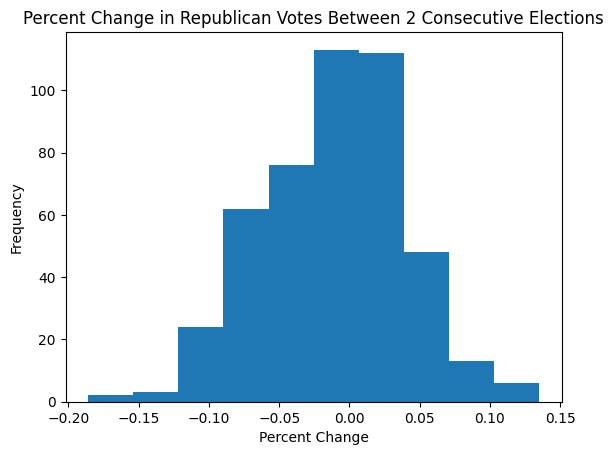

In [81]:
plot = (elections['result'] - elections['result_pres_4']).plot.hist()
plt.title('Percent Change in Republican Votes Between 2 Consecutive Elections')
plt.xlabel('Percent Change')

p = stat.ttest_1samp((elections['result'] - elections['result_pres_4']), 0).pvalue
print(f'p = {p:.10f}\n')

Because the $p$-value is less than the alpha value, there exists strong evidence to reject the null hypothesis. In this case, it means there *is* a significant difference between presidential results and presidential results 4 years prior, and there is more for us to explore!

#### **Method Two: Feature vs. Target Correlation**

result_pres_4 	 r^2 = 0.7222795833320625 	 p = 1.03391482235018e-126

result_pres_8 	 r^2 = 0.43391294150483073 	 p = 2.5231902580114264e-57

result_pres_12 	 r^2 = 0.34106552207989416 	 p = 1.6922117864287268e-42



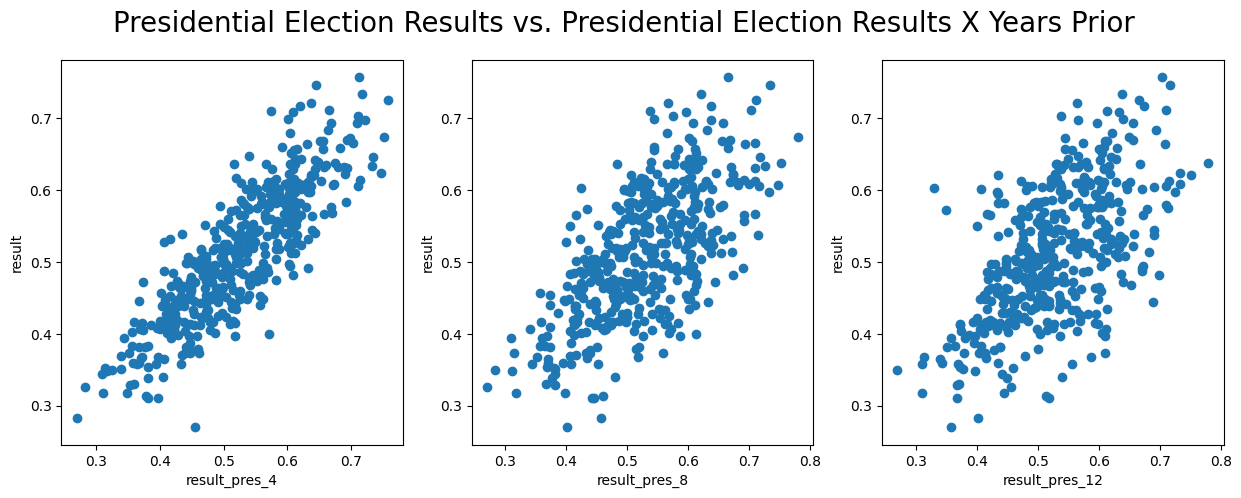

In [82]:
remove_outliers = True
outlier_z_thresh = 3

y = 'result'
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.suptitle('Presidential Election Results vs. Presidential Election Results X Years Prior', fontsize = '20')

# plotting presidential elections
for idx, i in enumerate([4, 8, 12]):
    x = f'result_pres_{i}'
    temp_elections = elections[[x, y]].dropna(axis = 0, how = 'any')
    if remove_outliers:
        temp_elections = temp_elections[(np.abs(zscore(temp_elections)) < outlier_z_thresh).all(axis = 1)]
    _,_,r,p,_ = linregress(temp_elections[x], temp_elections[y])
    print(f'{x} \t r^2 = {r**2} \t p = {p}\n')

    ax[idx].scatter(temp_elections[x], temp_elections[y])
    ax[idx].set_xlabel(x)
    ax[idx].set_ylabel(y)

_ = ''


Assuming there is no correlation between the target **result** and its features **result_pres_4**, **result_pres_8**, and **result_pres_12**, we must be really lucky to see a pattern in the scatterplots because $p$ is extremely small.

For **result** and **result_pres_4**, $R^{2}$ starts at 72% but as you compare **result** to presidential results further back, the value decreases and there is less of a correlation. This means presidential results are somewhat predictable from the previous election's results because $R^{2}$ is relatively high. There is also a correlation between the target and its features.

#### **Method Three: "Autocorrelation" for House Results**

result_house_4 	 r^2 = 0.5951354200067849 	 p = 3.25692821287722e-89

result_house_6 	 r^2 = 0.4608813687136928 	 p = 1.1075366687524688e-61

result_house_8 	 r^2 = 0.32589580677766494 	 p = 5.137519764165014e-40

result_house_10 	 r^2 = 0.24454155910012204 	 p = 6.056779858023315e-29

result_house_12 	 r^2 = 0.24473392450858666 	 p = 6.590175639304329e-29



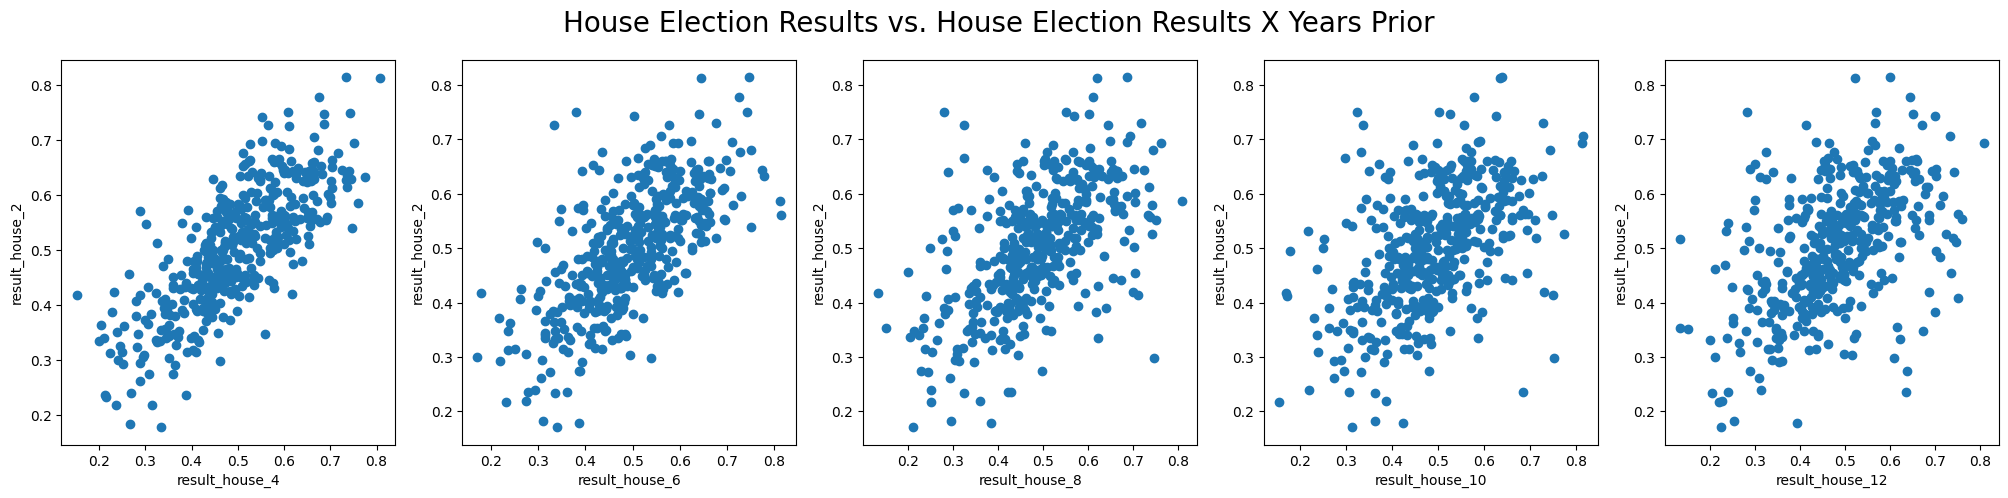

In [83]:
remove_outliers = True
outlier_z_thresh = 3

y = 'result_house_2'
fig, ax = plt.subplots(1, 5, figsize = (25, 5))
fig.suptitle('House Election Results vs. House Election Results X Years Prior', fontsize = '20')

# plotting house elections
for idx, i in enumerate([4, 6, 8, 10, 12]):
    x = f'result_house_{i}'
    temp_elections = elections[[x, y]].dropna(axis = 0, how = 'any')
    if remove_outliers:
        temp_elections = temp_elections[(np.abs(zscore(temp_elections)) < outlier_z_thresh).all(axis = 1)]
    _,_,r,p,_ = linregress(temp_elections[x], temp_elections[y])
    print(f'{x} \t r^2 = {r**2} \t p = {p}\n')

    ax[idx].scatter(temp_elections[x], temp_elections[y])
    ax[idx].set_xlabel(x)
    ax[idx].set_ylabel(y)

_ = ''

Assuming there is no correlation between the feature **result_house_2** and other house-related features (**result_house_4**, **result_house_6**, **result_house_8**, **result_house_10**, **result_house_12**), we must be really lucky to see a pattern in the scatterplots because, similar to **Method Two**, $p$ is extremely small.

The $R^{2}$ values begin somewhat high for the house results and decrease as you look further back, so the variation in **result_house_2** is best explained by the variation in **result_house_4**. The scatterplots also show that the feature **result_house_2** is correlated to the other house-related features.

### **Primary Analysis**

The machine learning technique we will be using is [Elastic Net Regression](https://machinelearningcompass.com/machine_learning_models/elastic_net_regression/).

During the Exploratory Data Analysis, we found that the target **result** was correlated to presidential-related features, and that house-related features were also correlated with one another. We will be using [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html) to conduct feature selection, which will help us determine what features are the most significant in predicting Presidential Election results.


We need to create the model and initialize the target (**result**) and features (previous election results) to train and test the data using [cross-validation](https://www.geeksforgeeks.org/cross-validation-machine-learning/).

In [85]:
# Drops rows with missing data for training
elections = elections.dropna(axis = 0, how = 'any')

model = ElasticNetCV(cv = 5)

target = 'result'
features = elections.columns.drop(['year', 'state', 'result'])

X = elections[features]
y = elections[target]

reg = model.fit(X,y)
reg.score(X,y)

for a in zip(X.columns, model.coef_):
    print(f'{a[0]} : {a[1]}')

print(f'intercept : {model.intercept_}')

result_house_2 : 0.1411935101577491
result_pres_4 : 0.9245552983295046
result_house_4 : 0.0031052210907710695
result_house_6 : 0.006688981955338444
result_pres_8 : -0.37708368226485817
result_house_8 : -0.024033993344954253
result_house_10 : -0.004344622578869184
result_pres_12 : 0.2903784787430135
result_house_12 : -0.012454976353762965
intercept : 0.018499092128594075


Notice how some coefficients are very close to 0. One of Elastic Net Regression's advantages is that it brings the coefficients of the least significant variables close to 0. Because of their small values, we will drop the least significant variables (features): **result_house_4**, **result_house_6**, and **result_house_10**.

We will also drop **result_house_12** for this prediction because the coefficient is always less than the **intercept** and might be fitting noise.

Since we dropped some features, we must retrain the model.

In [86]:
# Retraining the model after dropping features
features = features.drop(['result_house_4', 'result_house_6', 'result_house_10', 'result_house_12'])

X = elections[features]

reg = model.fit(X,y)
reg.score(X,y)

for a in zip(X.columns, model.coef_):
    print(f'{a[0]} : {a[1]}')

print(f'intercept : {model.intercept_}')

result_house_2 : 0.1390983840786649
result_pres_4 : 0.9837503165460995
result_pres_8 : -0.45711420235420586
result_house_8 : -0.036566378169878816
result_pres_12 : 0.33208393242505546
intercept : 0.011740915669222363


The coefficients look good so we will select the features **result_house_2**, **result_pres_4**, **result_pres_8**, **result_house_8**, and **result_pres_12** for this prediction.

### **Visualization**

We can begin the prediction process using the features we selected. The variable **correct_preds** stores the predictions in **yhat** that were correct by comparing them to the actual Presidential Election results in **y**.

Since we are measuring the percentage of votes won by the Republican party, **correct_preds** are predictions in favor of the Republican party that were correct. This also means if **yhat** > 0.5, the prediction is that a Republican will win, and if **yhat** < 0.5, the prediction is that a Democrat will win.

In [87]:
yhat = reg.predict(X)
correct_preds = (yhat > 0.5) == (y > 0.5)

#### **Visualization One: Pie Chart**


The [pie chart](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) is used to show what percentage of model predictions were correct and incorrect.

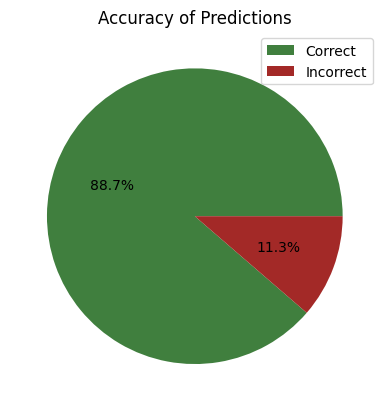

In [91]:
values = np.array([sum(correct_preds), sum(~correct_preds)])
colors = ['#407f3e', '#a32927']

plt.pie(values, colors = colors, autopct = '%1.1f%%')
plt.title('Accuracy of Predictions')
plt.legend(['Correct', 'Incorrect'])
plt.show()

As you can see, the predictions were mostly accurate, with the model correctly predicting almost 90% of the Presidential Election results. We can look further into this to see where the errors are coming from.

#### **Visualization Two: Scatterplot**

The [scatterplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) is used to show *which* model predictions were correct in comparison to the actual Presidential Election results, or the true values.

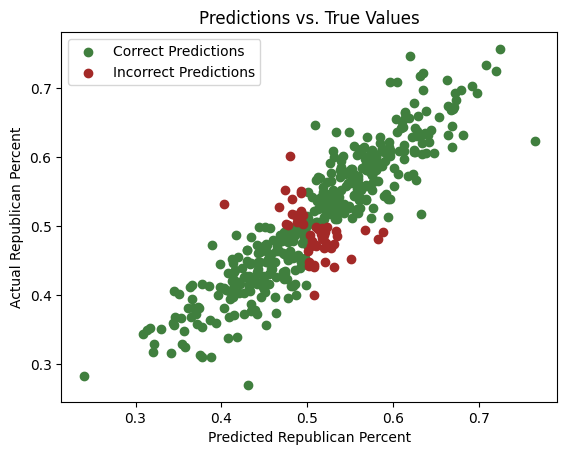

In [70]:
plt.scatter(yhat[correct_preds], y[correct_preds], color = '#407f3e', label = 'Correct Predictions')
plt.scatter(yhat[~correct_preds], y[~correct_preds], color = '#a32927', label = 'Incorrect Predictions')

plt.title('Predictions vs. True Values')
plt.xlabel('Predicted Republican Percent')
plt.ylabel('Actual Republican Percent')
plt.legend()
plt.show()

The plot shows us that the errors are clustered around the center, near the 0.5 mark on both the x- and y- axes.

Most of the model's correct predictions were for election results that clearly leaned toward one party (less than or greater than 0.5). The model had a more difficult time accurately predicting election results when the Republican percentage was around 50%, which makes sense as these results are more balanced between Democratic and Republican.

### **Insights and Conclusions**

We saw in the exploratory data analysis that Presidential Election results undergo significant change overtime and that those results are moderately correlated to previous election results. We also saw that house-related election results are correlated to one another.

Because of the correlation across features, we used machine learning to determine which features are the most important when predicting Presidential Election results. Our Elastic Net Regression model showed us that all 4 presidential-related features were important, but I find it interesting that only 2 house-related features, **results_house_2** and **results_house_8**, were deemed significant enough to keep. I want to assume this is because these are house results, aside from **results_house_12**, with a Presidential Election the following year.

We then predicted future election results using the selected features, tracking the accuracy of predictions in favor of the Republican party. The pie chart revealed that the model did a good job making predictions as almost 90% of the predictions were correct. The scatterplot showed us that the model was more likely to make an incorrect prediction if the true value was close to 0.5, meaning it straddled the Democrat-Republican line.

To answer the question at the beginning of this analysis: Previous elections can predict future elections quite well! By looking at past Presidential Election results, as well as House of Representatives Election results 2 years prior a presidential one, we can accurately predict future presidential elections.

